The Goal in this notebook is to test the performance of AWS EC2 (different configurations). I'll use time as the main measure to test different algos.

In [36]:
#the obvious stuff
import pandas as pd
import numpy as np
from collections import Counter
from ast import literal_eval

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.base import clone
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

from keras import utils

### Define Training and Testing data

read data using pandas, upload to AWS, then perform the train test split

In [39]:
data = pd.read_pickle('train_docket_processed.pkl')
data.head()

,Original Docket Text,Removed unnecessary POS & vocab,Removed unnecessary POS & vocab DT,feature,New Topocs,Action [Y/N],If Y,label
0,(REDACTED) RULE 56.1 STATEMENT. Document filed...,"['rule .', 'document file .']","['rule .', 'document file .']",rule document file,System Msg,N,NaN,0
1,***DELETED DOCUMENT. Deleted document number 1...,"['delete document .', 'delete document number ...","['delete document .', 'delete document number ...",delete document delete document number endorse...,System Msg,N,NaN,0
2,***DELETED DOCUMENT. Deleted document number 2...,"['delete document .', 'delete document number ...","['delete document .', 'delete document number ...",delete document delete document number rule do...,System Msg,N,NaN,0
3,***NOTE TO ATTORNEY OF NON-ECF CASE ERROR. Not...,"['note nonecf error .', 'note manually refile ...","['note nonecf error .', 'note manually refile ...",note nonecf error note manually refile documen...,System Msg,N,NaN,0
4,***NOTE TO ATTORNEY TO RE-FILE DOCUMENT - NON-...,"['note refile document nonecf error .', 'note ...","['note refile document nonecf error .', 'note ...",note refile document nonecf error note manuall...,System Msg,N,NaN,0


In [40]:
#do I need to balance out the dataset??
#reference: https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
Xtrain, Xtest, ytrain, ytest = train_test_split(data.feature, data.label, test_size = 0.2, random_state = 10)

### Text Transformation. A little different from previous attempts...

In [41]:
CV_vect = CountVectorizer() #Convert a collection of text documents to a matrix of token counts
TV_vect = TfidfVectorizer()

CV_vect.fit(Xtrain)
TV_vect.fit(Xtrain)

max_words = len(CV_vect.get_feature_names())
Keras_tokenize = Tokenizer(num_words = max_words, char_level = False)
Keras_tokenize.fit_on_texts(Xtrain)

In [42]:
print('CountVectorizer feature length: {}'.format(len(CV_vect.get_feature_names())))
print('TfidfVectorizer feature length: {}'.format(len(TV_vect.get_feature_names())))

CountVectorizer feature length: 817
TfidfVectorizer feature length: 817


In [43]:
#transform the train and test data into vectors, according to countvectorizer results
Xtrain_CV = CV_vect.transform(Xtrain)
Xtest_CV = CV_vect.transform(Xtest)

Xtrain_TV = TV_vect.transform(Xtrain)
Xtest_TV = TV_vect.transform(Xtest)

Xtrain_Keras = Keras_tokenize.texts_to_matrix(Xtrain)
Xtest_Keras = Keras_tokenize.texts_to_matrix(Xtest)

In [44]:
#print(Xtrain_CV.toarray()[0])
#print(Xtrain_TV.toarray()[0])
print(Xtrain_CV.toarray().shape)
print(Xtrain_TV.toarray().shape)
print(Xtrain_Keras.shape)

(500, 817)
(500, 817)
(500, 817)


In [45]:
#this is for keras only
num_classes = 2
ytrain_Keras = utils.to_categorical(ytrain, num_classes)
ytest_Keras = utils.to_categorical(ytest, num_classes)

In [46]:
print(ytrain_Keras[:10])
print(ytrain[:10])

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
197    1
152    1
6      1
100    1
217    0
192    1
351    1
326    1
519    1
278    0
Name: label, dtype: int64


### Machine Learning models - Default Hyperparameters

In [47]:
prediction = dict()
accuracy_scores = dict()

#### Gaussian Naive Bayes doesn't work with the dataset that we have

#### Multinomial Naive Bayes

In [35]:
%time
#remember to change 2 things: the id and the model algo
id = 'MNB'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = MultinomialNB()
    model.fit(Xtrain, ytrain)
    prediction[id + ' ' + label] = model.predict(Xtest)
    accuracy_scores[id + ' ' + label] = accuracy_score(ytest, prediction[id + ' ' + label])

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 0 ns
#AWS p2.xlarge time: 6.2 µs

Wall time: 0 ns
updated accuracy scores: [('MNB TV', 0.92), ('MNB CV', 0.904), ('MNB Keras', 0.816)]


#### Bernoulli Naive Bayes

In [36]:
%time
#remember to change 2 things: the id and the model algo
id = 'BNB'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = BernoulliNB()
    model.fit(Xtrain, ytrain)
    prediction[id + ' ' + label] = model.predict(Xtest)
    accuracy_scores[id + ' ' + label] = accuracy_score(ytest, prediction[id + ' ' + label])

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 0 ns
#AWS p2.xlarge time: 6.2 µs

Wall time: 0 ns
updated accuracy scores: [('MNB TV', 0.92), ('MNB CV', 0.904), ('BNB Keras', 0.904), ('MNB Keras', 0.816), ('BNB CV', 0.8), ('BNB TV', 0.8)]


#### Logistic Regression

In [37]:
%time
#remember to change 2 things: the id and the model algo
id = 'LR'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = LogisticRegression()
    model.fit(Xtrain, ytrain)
    prediction[id + ' ' + label] = model.predict(Xtest)
    accuracy_scores[id + ' ' + label] = accuracy_score(ytest, prediction[id + ' ' + label])

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 0 ns
#AWS p2.xlarge time: 6.44 µs

Wall time: 0 ns
updated accuracy scores: [('LR Keras', 0.928), ('LR TV', 0.928), ('LR CV', 0.92), ('MNB TV', 0.92), ('MNB CV', 0.904), ('BNB Keras', 0.904), ('MNB Keras', 0.816), ('BNB CV', 0.8), ('BNB TV', 0.8)]


#### KNN Classifier

In [38]:
%time
#remember to change 2 things: the id and the model algo
id = 'KNN'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = KNeighborsClassifier()
    model.fit(Xtrain, ytrain)
    prediction[id + ' ' + label] = model.predict(Xtest)
    accuracy_scores[id + ' ' + label] = accuracy_score(ytest, prediction[id + ' ' + label])

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key=lambda x: x[1], reverse=True)))
#CPU time: 0 ns
#AWS p2.xlarge time: 5.96 µs

Wall time: 0 ns
updated accuracy scores: [('LR Keras', 0.928), ('LR TV', 0.928), ('LR CV', 0.92), ('MNB TV', 0.92), ('BNB Keras', 0.904), ('MNB CV', 0.904), ('MNB Keras', 0.816), ('KNN Keras', 0.8), ('BNB CV', 0.8), ('BNB TV', 0.8), ('KNN TV', 0.744), ('KNN CV', 0.736)]


#### SVM Classifier

In [39]:
%time
#remember to change 2 things: the id and the model algo
id = 'SVM'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = SVC()
    model.fit(Xtrain, ytrain)
    prediction[id + ' ' + label] = model.predict(Xtest)
    accuracy_scores[id + ' ' + label] = accuracy_score(ytest, prediction[id + ' ' + label])

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key=lambda x: x[1], reverse=True)))
#CPU time: 0 ns
#AWS p2.xlarge time: 6.2 µs

Wall time: 0 ns
updated accuracy scores: [('LR Keras', 0.928), ('LR TV', 0.928), ('LR CV', 0.92), ('MNB TV', 0.92), ('BNB Keras', 0.904), ('MNB CV', 0.904), ('MNB Keras', 0.816), ('KNN Keras', 0.8), ('BNB CV', 0.8), ('BNB TV', 0.8), ('KNN TV', 0.744), ('KNN CV', 0.736), ('SVM TV', 0.672), ('SVM CV', 0.672), ('SVM Keras', 0.672)]


#### Ensemble Classifier: Random Forest

In [40]:
%time
#remember to change 2 things: the id and the model algo
id = 'RF'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = RandomForestClassifier()
    model.fit(Xtrain, ytrain)
    prediction[id + ' ' + label] = model.predict(Xtest)
    accuracy_scores[id + ' ' + label] = accuracy_score(ytest, prediction[id + ' ' + label])

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 
#AWS p2.xlarge time: 6.2 µs

Wall time: 0 ns
updated accuracy scores: [('RF Keras', 0.936), ('RF CV', 0.936), ('LR Keras', 0.928), ('LR TV', 0.928), ('LR CV', 0.92), ('RF TV', 0.92), ('MNB TV', 0.92), ('BNB Keras', 0.904), ('MNB CV', 0.904), ('MNB Keras', 0.816), ('KNN Keras', 0.8), ('BNB CV', 0.8), ('BNB TV', 0.8), ('KNN TV', 0.744), ('KNN CV', 0.736), ('SVM TV', 0.672), ('SVM CV', 0.672), ('SVM Keras', 0.672)]


#### Ensemble Classifier: AdaBoost

In [41]:
%time
#remember to change 2 things: the id and the model algo
id = 'AB'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = AdaBoostClassifier()
    model.fit(Xtrain, ytrain)
    prediction[id + ' ' + label] = model.predict(Xtest)
    accuracy_scores[id + ' ' + label] = accuracy_score(ytest, prediction[id + ' ' + label])

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 
#AWS p2.xlarge time: 6.44 µs

Wall time: 0 ns
updated accuracy scores: [('AB CV', 0.936), ('AB Keras', 0.936), ('RF Keras', 0.936), ('RF CV', 0.936), ('AB TV', 0.936), ('LR Keras', 0.928), ('LR TV', 0.928), ('LR CV', 0.92), ('RF TV', 0.92), ('MNB TV', 0.92), ('BNB Keras', 0.904), ('MNB CV', 0.904), ('MNB Keras', 0.816), ('KNN Keras', 0.8), ('BNB CV', 0.8), ('BNB TV', 0.8), ('KNN TV', 0.744), ('KNN CV', 0.736), ('SVM TV', 0.672), ('SVM CV', 0.672), ('SVM Keras', 0.672)]


#### XGBoost

In [42]:
%time
#remember to change 2 things: the id and the model algo
id = 'XGB'
for Xtrain, Xtest, label in zip([Xtrain_CV.toarray(), Xtrain_TV.toarray(), Xtrain_Keras], 
                                [Xtest_CV.toarray(), Xtest_TV.toarray(), Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = XGBClassifier()
    model.fit(Xtrain, ytrain)
    prediction[id + ' ' + label] = model.predict(Xtest)
    accuracy_scores[id + ' ' + label] = accuracy_score(ytest, prediction[id + ' ' + label])

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 
#AWS p2.xlarge time: 6.2 µs

Wall time: 0 ns


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


updated accuracy scores: [('AB Keras', 0.936), ('RF CV', 0.936), ('AB TV', 0.936), ('AB CV', 0.936), ('RF Keras', 0.936), ('LR Keras', 0.928), ('LR TV', 0.928), ('XGB Keras', 0.92), ('MNB TV', 0.92), ('LR CV', 0.92), ('RF TV', 0.92), ('XGB CV', 0.912), ('XGB TV', 0.912), ('BNB Keras', 0.904), ('MNB CV', 0.904), ('MNB Keras', 0.816), ('KNN Keras', 0.8), ('BNB TV', 0.8), ('BNB CV', 0.8), ('KNN TV', 0.744), ('KNN CV', 0.736), ('SVM TV', 0.672), ('SVM CV', 0.672), ('SVM Keras', 0.672)]


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Keras

In [ ]:
%time
batch_size = 10
epochs = 10

model = Sequential()
model.add(Dense(512, input_shape = (Xtrain_CV.shape[1], )))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model.fit(Xtrain_Keras, ytrain_Keras, batch_size = batch_size, epochs = epochs, verbose = 1, validation_split = 0.1)
#CPU time: 
#AWS p2.xlarge time: 6.2 µs

In [44]:
%time
# Evaluate the accuracy of our trained model
score = model.evaluate(Xtest_Keras, ytest_Keras, batch_size = batch_size, verbose = 1)
print('\nTest score (loss value:', score[0])
print('Test accuracy:', score[1])

accuracy_scores['Keras'] = score[1]

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 
#AWS p2.xlarge time: 6.91 µs

Wall time: 0 ns
 10/125 [=>............................] - ETA: 0s
Test score (loss value: 0.29245427120476963
Test accuracy: 0.9359999918937683
updated accuracy scores: [('AB Keras', 0.936), ('RF CV', 0.936), ('AB TV', 0.936), ('AB CV', 0.936), ('RF Keras', 0.936), ('Keras', 0.9359999918937683), ('LR Keras', 0.928), ('LR TV', 0.928), ('XGB Keras', 0.92), ('MNB TV', 0.92), ('LR CV', 0.92), ('RF TV', 0.92), ('XGB CV', 0.912), ('XGB TV', 0.912), ('BNB Keras', 0.904), ('MNB CV', 0.904), ('MNB Keras', 0.816), ('KNN Keras', 0.8), ('BNB TV', 0.8), ('BNB CV', 0.8), ('KNN TV', 0.744), ('KNN CV', 0.736), ('SVM TV', 0.672), ('SVM CV', 0.672), ('SVM Keras', 0.672)]


### Parameter Tuning using GridSearchCV
Let's pick the top algos/dataset treatment, and see if GridSearchCV can improve the accuracies:
1. 'RF  Keras': 0.944
2. 'AB Keras': 0.936
3. 'RF CV': 0.936
4. 'AB CV': 0.936
5. 'AB TV': 0.936
6. 'LR Keras': 928
7. 'XGB TV': 0.912

The top four algos are RandomForest, AdaBoost, LogisticRegression and XGB. Let's see if we can tune them to perform better:

#### setup a gridsearch pipeline

In [ ]:
def gridsearch(model, param_grid, cvs, X, y, plot = False):

    acc_by_cv = []
    print('selecting best cv parameter:')
    for cv in cvs:
        cloned_model = clone(model, safe = True)
        grid = GridSearchCV(cloned_model, param_grid = param_grid, n_jobs = 4, cv = cv)
        grid.fit(X, y)
        acc_by_cv.append(grid.best_score_)
        print(cv, ': ')
        print(grid.best_score_) #{'ABC': 0.92, 'KNNC': 0.8, 'LR': 0.928, 'MNB': 0.848, 'RFC': 0.944}
        print(grid.best_estimator_)
    
    best_cv = cvs[np.argmax(acc_by_cv)]
    print('\nbest cv: ', best_cv)
    
    cloned_model = clone(model, safe = True)
    grid = GridSearchCV(cloned_model, param_grid = param_grid, n_jobs = 4, cv = best_cv)
    grid.fit(X, y)
    print(grid.best_score_) #{'ABC': 0.92, 'KNNC': 0.8, 'LR': 0.928, 'MNB': 0.848, 'RFC': 0.944}
    print(grid.best_estimator_)
    print(grid.grid_scores_)
    
    if plot:
        plt.plot(cvs, acc_by_cv)
        plt.show()
        
    return grid.best_estimator_, pd.DataFrame(grid.grid_scores_), best_cv

#### RandomForestClassifier

selecting best cv parameter:
2 : 
0.922
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
3 : 
0.93
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=75, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
4 : 
0.938
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_sp

23 : 
0.94
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=60, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
24 : 
0.94
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=85, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
25 : 
0.94
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


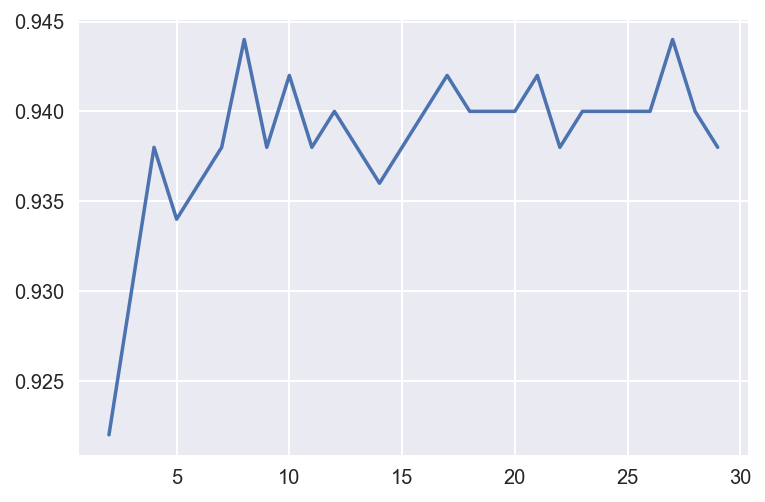

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


selecting best cv parameter:
2 : 
0.918
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
3 : 
0.93
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=60, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
4 : 
0.936
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_sp

23 : 
0.938
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
24 : 
0.938
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=15, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
25 : 
0.936
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_l

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


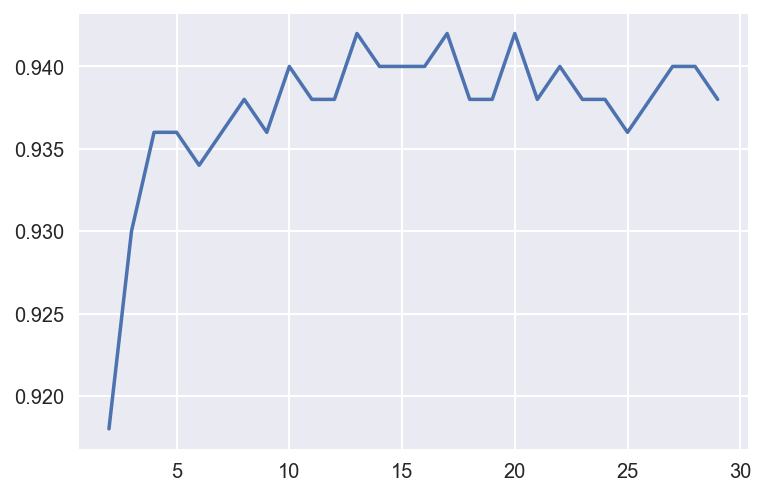

selecting best cv parameter:

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)



2 : 
0.93
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=95, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
3 : 
0.938
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=65, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
4 : 
0.942
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=

23 : 
0.95
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
24 : 
0.948
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=95, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
25 : 
0.948
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_lea

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


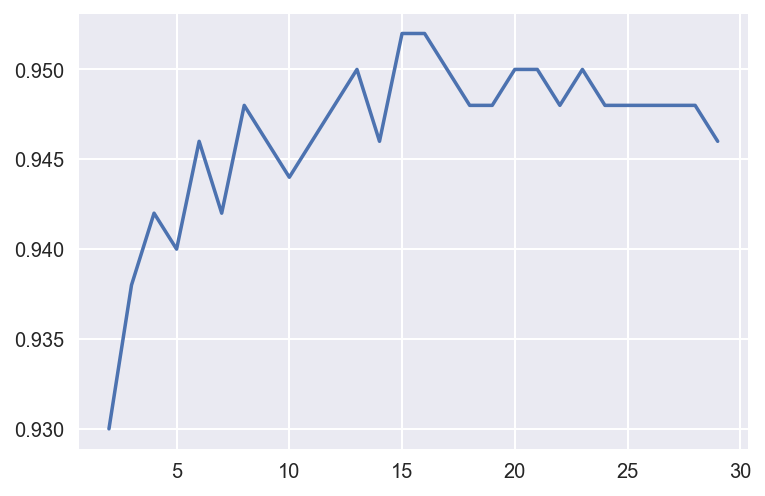

Wall time: 2h 52min 8s


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [46]:
%%time
cvs = range(2, 30)
RF_dict = {}
param_grid = {'n_estimators': range(5, 105, 5),
              'max_features': ['auto', 'sqrt', 'log2', None]}
for Xtrain, label in zip([Xtrain_Keras, Xtrain_CV, Xtrain_TV], ['Keras', 'CV', 'TV']):
    model = RandomForestClassifier(n_jobs = 4)
    RF_dict['opt model ' + label], RF_dict['summary df ' + label], RF_dict['cv ' + label] = gridsearch(model, param_grid, cvs, Xtrain, ytrain, plot = True)

#CPU time: 2h 52min 8s
#AWS p2.xlarge time: 

In [45]:
print('top score was 0.944')
for key in ['CV', 'TV', 'Keras']:
    print('accuracy scores for {} is {}'.format(key, RF_dict['summary df ' + key]['mean_validation_score'].iloc[RF_dict['summary df ' + key]['mean_validation_score'].argmax()]))
    print('parameters for model {} is {}'.format(key, RF_dict['summary df ' + key]['parameters'].iloc[RF_dict['summary df ' + key]['mean_validation_score'].argmax()]))

top score was 0.944
accuracy scores for CV is 0.942
parameters for model CV is {'n_estimators': 70, 'max_features': 'log2'}
accuracy scores for TV is 0.946
parameters for model TV is {'n_estimators': 65, 'max_features': 'sqrt'}
accuracy scores for Keras is 0.94
parameters for model Keras is {'n_estimators': 45, 'max_features': 'log2'}


#### AdaBoost

selecting best cv parameter:
2 : 
0.926
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=80, random_state=None)
3 : 
0.938
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=55, random_state=None)
4 : 
0.934
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=40, random_state=None)
5 : 
0.942
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=85, random_state=None)
6 : 
0.938
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=95, random_state=None)
7 : 
0.94
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=80, random_state=None)
8 : 
0.94
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=55, random_state=None)
9 : 
0.936
AdaBoostC

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


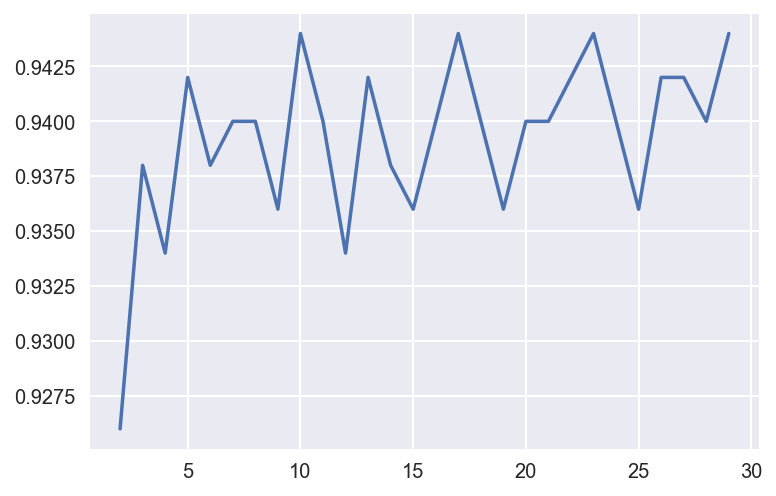

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


selecting best cv parameter:
2 : 
0.916
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=100, random_state=None)
3 : 
0.934
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=85, random_state=None)
4 : 
0.926
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=40, random_state=None)
5 : 
0.932
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=55, random_state=None)
6 : 
0.934
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=55, random_state=None)
7 : 
0.926
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=70, random_state=None)
8 : 
0.93
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=65, random_state=None)
9 : 
0.932
AdaBoostC

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


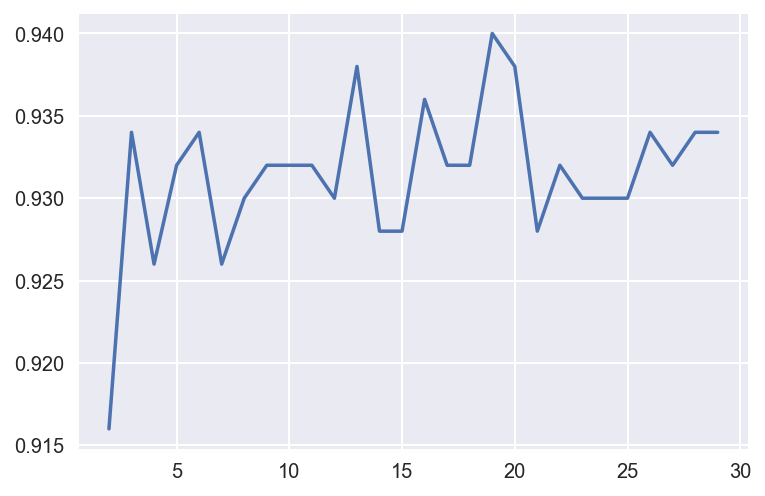

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


selecting best cv parameter:
2 : 
0.93
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=40, random_state=None)
3 : 
0.934
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=95, random_state=None)
4 : 
0.938
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=80, random_state=None)
5 : 
0.934
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=100, random_state=None)
6 : 
0.932
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=95, random_state=None)
7 : 
0.932
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=55, random_state=None)
8 : 
0.938
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=90, random_state=None)
9 : 
0.938
AdaBoostC

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


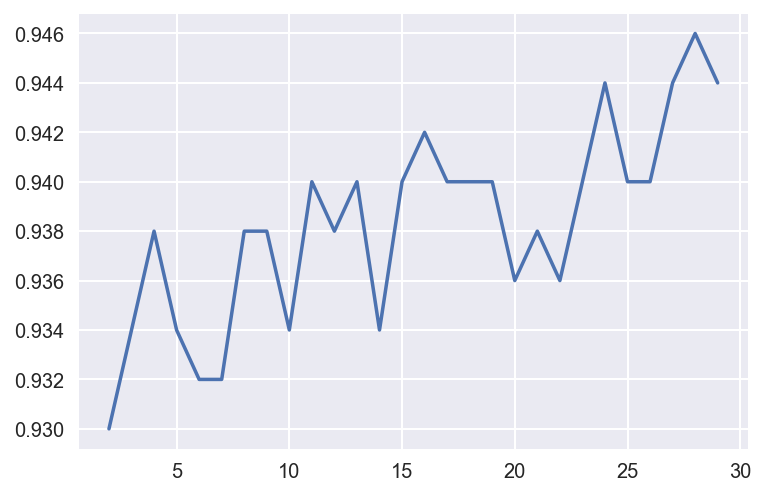

Wall time: 2h 12min 42s


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [36]:
%%time
cvs = range(2, 30)
AB_dict = {}
param_grid = {'n_estimators': range(5, 105, 5),
              'learning_rate': [0.01, 0.1, 0.5, 1, 2, 10, 100]}
for Xtrain, label in zip([Xtrain_Keras, Xtrain_CV, Xtrain_TV], ['Keras', 'CV', 'TV']):
    model = AdaBoostClassifier()
    AB_dict['opt model ' + label], AB_dict['summary df ' + label], AB_dict['cv ' + label] = gridsearch(model, param_grid, cvs, Xtrain, ytrain, plot = True)

#CPU time: 2h 12min 42s
#AWS p2.xlarge time: 

In [37]:
print('top score was 0.944')
for key in ['CV', 'TV', 'Keras']:
    print('accuracy scores for {} is {}'.format(key, AB_dict['summary df ' + key]['mean_validation_score'].iloc[AB_dict['summary df ' + key]['mean_validation_score'].argmax()]))
    print('parameters for model {} is {}'.format(key, AB_dict['summary df ' + key]['parameters'].iloc[AB_dict['summary df ' + key]['mean_validation_score'].argmax()]))

top score was 0.944
accuracy scores for CV is 0.942
parameters for model CV is {'learning_rate': 1, 'n_estimators': 55}
accuracy scores for TV is 0.946
parameters for model TV is {'learning_rate': 1, 'n_estimators': 60}
accuracy scores for Keras is 0.944
parameters for model Keras is {'learning_rate': 0.5, 'n_estimators': 75}


#### Logistic Regression

selecting best cv parameter:
2 : 
0.92
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
3 : 
0.916
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
4 : 
0.912
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
5 : 
0.92
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class=

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


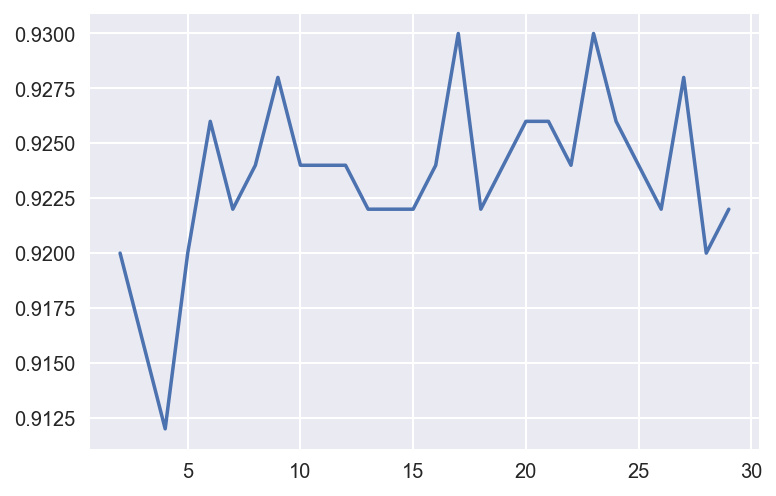

selecting best cv parameter:

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)



2 : 
0.912
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
3 : 
0.928
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
4 : 
0.934
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
5 : 
0.928
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
         

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


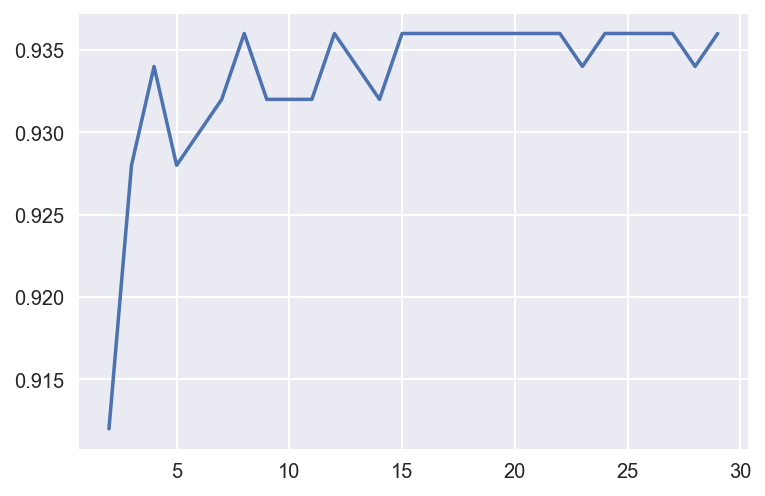

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


selecting best cv parameter:
2 : 
0.826
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
3 : 
0.868
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
4 : 
0.872
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
5 : 
0.872
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_clas

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


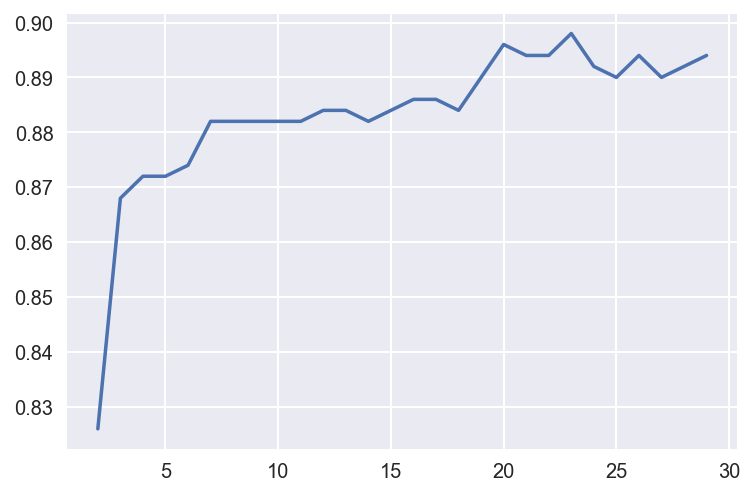

Wall time: 5min 56s


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [47]:
%%time
cvs = range(2, 30)
LR_dict = {}
param_grid = {'solver': ['liblinear'],
              'penalty': ['l1', 'l2']}

for Xtrain, label in zip([Xtrain_Keras, Xtrain_CV, Xtrain_TV], ['Keras', 'CV', 'TV']):
    model = LogisticRegression()
    LR_dict['opt model ' + label], LR_dict['summary df ' + label], LR_dict['cv ' + label] = gridsearch(model, param_grid, cvs, Xtrain, ytrain, plot = True)
    
#CPU time: 5min 48s
#AWS p2.xlarge time: 

In [48]:
print('top score was 0.944')
for key in ['CV', 'TV', 'Keras']:
    print('accuracy scores for {} is {}'.format(key, LR_dict['summary df ' + key]['mean_validation_score'].iloc[LR_dict['summary df ' + key]['mean_validation_score'].argmax()]))
    print('parameters for model {} is {}'.format(key, LR_dict['summary df ' + key]['parameters'].iloc[LR_dict['summary df ' + key]['mean_validation_score'].argmax()]))

top score was 0.944
accuracy scores for CV is 0.936
parameters for model CV is {'penalty': 'l2', 'solver': 'liblinear'}
accuracy scores for TV is 0.898
parameters for model TV is {'penalty': 'l1', 'solver': 'liblinear'}
accuracy scores for Keras is 0.93
parameters for model Keras is {'penalty': 'l2', 'solver': 'liblinear'}


#### XGBoost

selecting best cv parameter:
2 : 
0.888
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=5, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
3 : 
0.9
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=10, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
4 : 
0.904
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=2, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scal

26 : 
0.916
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=1.5, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=5, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
27 : 
0.924
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=5, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
28 : 
0.916
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=7, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, s

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


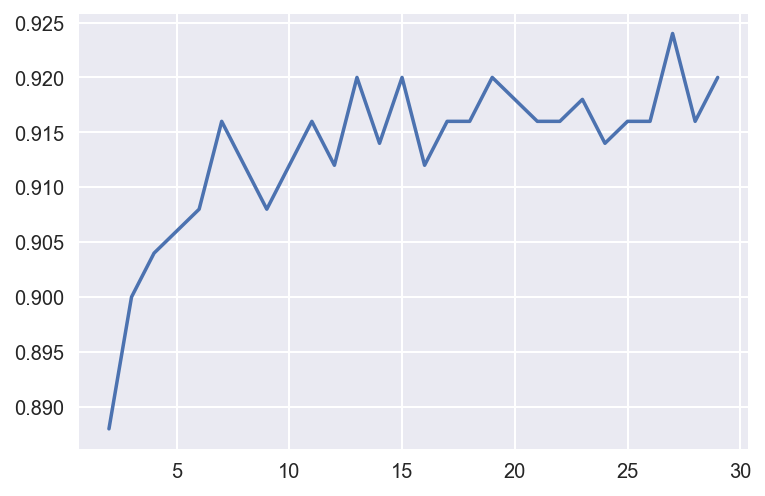

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


selecting best cv parameter:
2 : 
0.86
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=1.5, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=7, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
3 : 
0.884
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=1, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=None, n_estimators=10, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
4 : 
0.894
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=7, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       s

26 : 
0.908
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=1, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=None, n_estimators=10, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
27 : 
0.912
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=1.5, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=7, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
28 : 
0.91
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=1, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=None, n_estimators=5, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, s

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


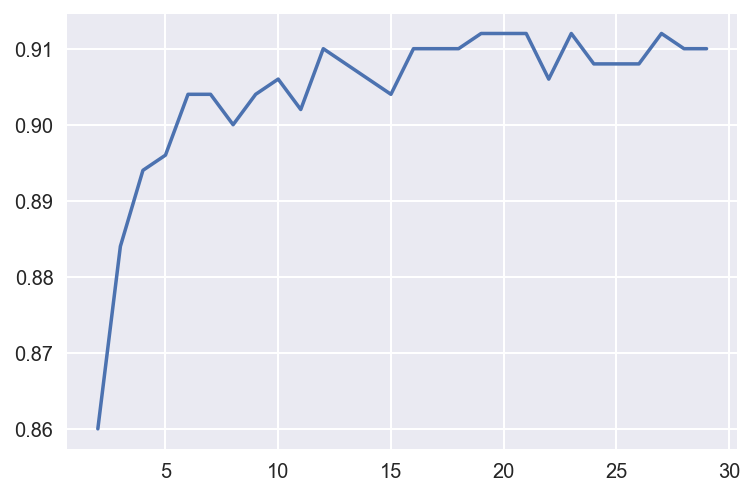

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


selecting best cv parameter:
2 : 
0.884
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=7, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
3 : 
0.892
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=10, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
4 : 
0.912
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=1.5, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=7, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       sc

26 : 
0.928
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=None, n_estimators=10, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
27 : 
0.922
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=5, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
28 : 
0.926
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=None, n_estimators=7, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0,

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


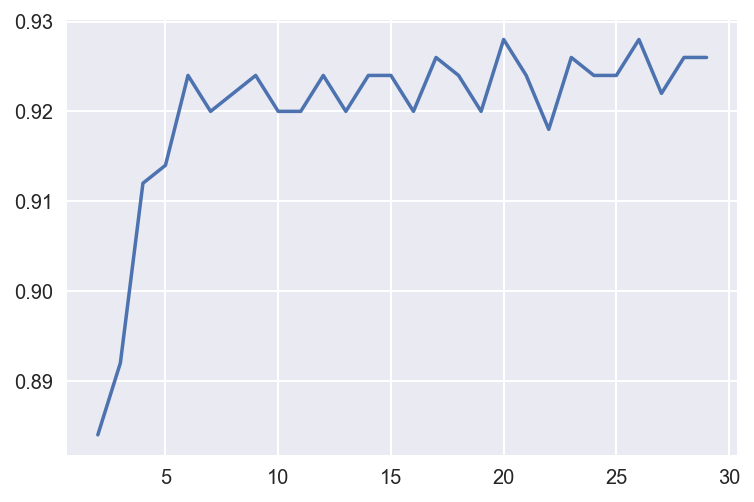

Wall time: 43min 10s


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [53]:
%%time
cvs = range(2, 30)
XGB_dict = {}
param_grid = {'learning_rate': [0.5, 1, 1.5],
              'max_depth': [8, 10, 12],
              'n_estimators': [2, 5, 7, 10]}

for Xtrain, label in zip([Xtrain_Keras, Xtrain_CV.toarray(), Xtrain_TV.toarray()], ['Keras', 'CV', 'TV']):
    model = XGBClassifier()
    XGB_dict['opt model ' + label], XGB_dict['summary df ' + label], XGB_dict['cv ' + label] = gridsearch(model, param_grid, cvs, Xtrain, ytrain, plot = True)
    
#CPU time: 43min 10s
#AWS p2.xlarge time: 

In [54]:
print('top score was 0.944')
for key in ['CV', 'TV', 'Keras']:
    print('accuracy scores for {} is {}'.format(key, XGB_dict['summary df ' + key]['mean_validation_score'].iloc[XGB_dict['summary df ' + key]['mean_validation_score'].argmax()]))
    print('parameters for model {} is {}'.format(key, XGB_dict['summary df ' + key]['parameters'].iloc[XGB_dict['summary df ' + key]['mean_validation_score'].argmax()]))
    
#CPU time: 
#AWS p2.xlarge time: 

top score was 0.944
accuracy scores for CV is 0.912
parameters for model CV is {'max_depth': 12, 'n_estimators': 10, 'learning_rate': 1}
accuracy scores for TV is 0.928
parameters for model TV is {'max_depth': 12, 'n_estimators': 7, 'learning_rate': 0.5}
accuracy scores for Keras is 0.924
parameters for model Keras is {'max_depth': 10, 'n_estimators': 5, 'learning_rate': 1}


#### Keras

Optimizing Neural Network is a little bit tricky. As we can only use one dataset, we'll test out different deep network structures. Also, this takes really really long time to optimize. We might need to move this to AWS to try out.

In [40]:
def keras1(optimizer):
    model = Sequential()
    model.add(Dense(1025, input_shape = (Xtrain_Keras.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

def keras2(optimizer):
    model = Sequential()
    model.add(Dense(512, input_shape = (Xtrain_Keras.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

def keras3(optimizer):
    model = Sequential()
    model.add(Dense(512, input_shape = (Xtrain_Keras.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

def keras4(optimizer):
    model = Sequential()
    model.add(Dense(1024, input_shape = (Xtrain_Keras.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

def keras5(optimizer):
    model = Sequential()
    model.add(Dense(512, input_shape = (Xtrain_Keras.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

In [ ]:
%%time
cvs = range(2, 30)
Keras1_dict = {}
param_grid = {'batch_size': [20, 50],
              'epochs': [100, 500],
              'optimizer': ['adam', 'rmsprop']}

for Xtrain, label in zip([Xtrain_CV.toarray(), Xtrain_TV.toarray(), Xtrain_Keras], ['CV', 'TV', 'Keras']):
    model = KerasClassifier(build_fn = keras1, verbose = False)
    Keras_dict1['opt model ' + label], Keras_dict1['summary df ' + label], Keras_dict1['cv ' + label] = gridsearch(model, param_grid, cvs, Xtrain, ytrain, plot = True)
    
#CPU time: 
#AWS p2.xlarge time: 

selecting best cv parameter:


In [ ]:
%%time
cvs = range(2, 30)
Keras2_dict = {}
param_grid = {'batch_size': [20, 50],
              'epochs': [100, 500],
              'optimizer': ['adam', 'rmsprop']}

for Xtrain, label in zip([Xtrain_CV.toarray(), Xtrain_TV.toarray(), Xtrain_Keras], ['CV', 'TV', 'Keras']):
    model = KerasClassifier(build_fn = keras2, verbose = False)
    Keras2_dict['opt model ' + label], Keras2_dict['summary df ' + label], Keras2_dict['cv ' + label] = gridsearch(model, param_grid, cvs, Xtrain, ytrain, plot = True)
        
#CPU time: 
#AWS p2.xlarge time: 

In [ ]:
%%time
cvs = range(2, 30)
Keras3_dict = {}
param_grid = {'batch_size': [20, 50],
              'epochs': [100, 500],
              'optimizer': ['adam', 'rmsprop']}

for Xtrain, label in zip([Xtrain_CV.toarray(), Xtrain_TV.toarray(), Xtrain_Keras], ['CV', 'TV', 'Keras']):
    model = KerasClassifier(build_fn = keras3, verbose = False)
    Keras3_dict['opt model ' + label], Keras3_dict['summary df ' + label], Keras3_dict['cv ' + label] = gridsearch(model, param_grid, cvs, Xtrain, ytrain, plot = True)
        
#CPU time: 
#AWS p2.xlarge time: 

In [ ]:
%%time
cvs = range(2, 30)
Keras4_dict = {}
param_grid = {'batch_size': [20, 50],
              'epochs': [100, 500],
              'optimizer': ['adam', 'rmsprop']}

for Xtrain, label in zip([Xtrain_CV.toarray(), Xtrain_TV.toarray(), Xtrain_Keras], ['CV', 'TV', 'Keras']):
    model = KerasClassifier(build_fn = keras4, verbose = False)
    Keras4_dict['opt model ' + label], Keras4_dict['summary df ' + label], Keras4_dict['cv ' + label] = gridsearch(model, param_grid, cvs, Xtrain, ytrain, plot = True)
        
#CPU time: 
#AWS p2.xlarge time: 

In [ ]:
%%time
cvs = range(2, 30)
Keras5_dict = {}
param_grid = {'batch_size': [20, 50],
              'epochs': [100, 500],
              'optimizer': ['adam', 'rmsprop']}

for Xtrain, label in zip([Xtrain_CV.toarray(), Xtrain_TV.toarray(), Xtrain_Keras], ['CV', 'TV', 'Keras']):
    model = KerasClassifier(build_fn = keras5, verbose = False)
    Keras5_dict['opt model ' + label], Keras5_dict['summary df ' + label], Keras5_dict['cv ' + label] = gridsearch(model, param_grid, cvs, Xtrain, ytrain, plot = True)
    
#CPU time: 
#AWS p2.xlarge time: 

In [50]:
Keras_dict1 = Keras_dict

{'Keras1': [mean: 0.93400, std: 0.02691, params: {'optimizer': 'adam', 'batch_size': 20, 'epochs': 10},
  mean: 0.93000, std: 0.02864, params: {'optimizer': 'rmsprop', 'batch_size': 20, 'epochs': 10},
  mean: 0.93600, std: 0.02939, params: {'optimizer': 'adam', 'batch_size': 20, 'epochs': 100},
  mean: 0.93800, std: 0.03156, params: {'optimizer': 'rmsprop', 'batch_size': 20, 'epochs': 100},
  mean: 0.92600, std: 0.03470, params: {'optimizer': 'adam', 'batch_size': 20, 'epochs': 500},
  mean: 0.94000, std: 0.03098, params: {'optimizer': 'rmsprop', 'batch_size': 20, 'epochs': 500},
  mean: 0.93200, std: 0.02713, params: {'optimizer': 'adam', 'batch_size': 30, 'epochs': 10},
  mean: 0.93800, std: 0.02750, params: {'optimizer': 'rmsprop', 'batch_size': 30, 'epochs': 10},
  mean: 0.93600, std: 0.03072, params: {'optimizer': 'adam', 'batch_size': 30, 'epochs': 100},
  mean: 0.94200, std: 0.02750, params: {'optimizer': 'rmsprop', 'batch_size': 30, 'epochs': 100},
  mean: 0.93200, std: 0.02993

In [41]:
%%time
cvs = range(2, 30)
Keras_dict = {}
param_grid = {'batch_size': [25, 30, 50],
              'epochs': [10, 100, 500, 1000],
              'optimizer': ['adam', 'rmsprop']}


for model, label in zip([KerasClassifier(build_fn = keras1, verbose = False), KerasClassifier(build_fn = keras2, verbose = False),
                         KerasClassifier(build_fn = keras3, verbose = False), KerasClassifier(build_fn = keras4, verbose = False),
                         KerasClassifier(build_fn = keras5, verbose = False)], ['Keras1', 'Keras2', 'Keras3', 'Keras4', 'Keras5']):
    grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = 10)
    grid = grid.fit(Xtrain_Keras, ytrain_Keras)
    Keras_dict[label] = grid.grid_scores_


ValueError: y_true and y_pred have different number of output (2!=1)

In [ ]:
Keras_dict

In [ ]:

history = model.fit(, , batch_size = batch_size, epochs = epochs, verbose = 1, validation_split = 0.1)

In [153]:
# Evaluate the accuracy of our trained model
score = model.evaluate(Xtest_Keras, ytest_Keras, batch_size = batch_size, verbose = 1)
print('\nTest score (loss value:', score[0])
print('Test accuracy:', score[1])

accuracy_scores['Keras'] = score[1]

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key = lambda x: x[1], reverse = True)))

0.9278557114228457
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [114]:
print(classification_report(y_test, prediction['Multinomial'], target_names = ['Ham', 'Spam']))

             precision    recall  f1-score   support

        Ham       0.99      0.99      0.99       965
       Spam       0.97      0.95      0.96       150

avg / total       0.99      0.99      0.99      1115



In [115]:
conf_mat = confusion_matrix(y_test, prediction['Multinomial'])
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis = 1)[:, np.newaxis]

Text(0.5,16,'Predicted label')

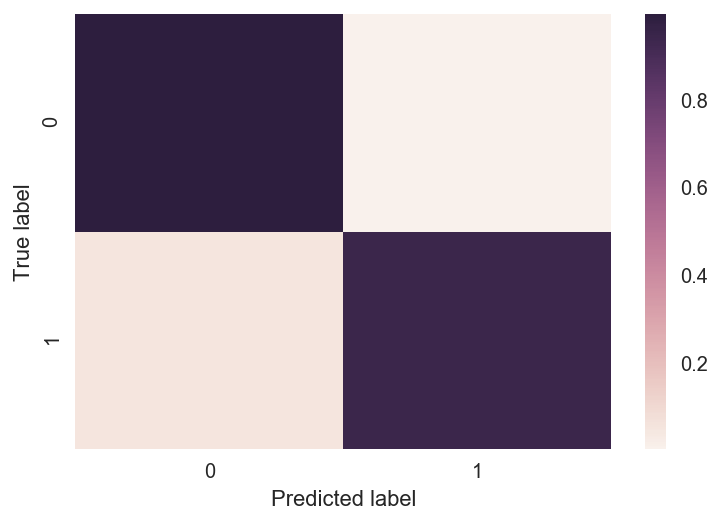

In [116]:
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Future works

In [117]:
print(conf_mat)

[[960   5]
 [  8 142]]


In [118]:
pd.set_option('display.max_colwidth', -1)

#### Misclassified as Spam

In [122]:
X_test[y_test < prediction['Multinomial']]

573     Waiting for your call.                                                                                                      
4727    I (Career Tel) have added u as a contact on INDYAROCKS.COM to send FREE SMS. To remove from phonebook - sms NO to  &lt;#&gt;
5475    Dhoni have luck to win some big title.so we will win:)                                                                      
4860    Nokia phone is lovly..                                                                                                      
1259    We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us                           
Name: text, dtype: object

#### Misclassfied as Ham

In [120]:
X_test[y_test > prediction['Multinomial']]

5035    You won't believe it but it's true. It's Incredible Txts! Reply G now to learn truly amazing things that will blow your mind. From O2FWD only 18p/txt       
2574    Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one vid is not enough for 2day text back the keyword PICSFREE1 to get the next video.   
3130    LookAtMe!: Thanks for your purchase of a video clip from LookAtMe!, you've been charged 35p. Think you can do better? Why not send a video in a MMSto 32323.
68      Did you hear about the new \Divorce Barbie\"? It comes with all of Ken's stuff!"                                                                            
2662    Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy?                          
4211    Missed call alert. These numbers called but left no message. 07008009200                                                                                    
3572    Yo